In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline
from sklearn import preprocessing
import matplotlib.pyplot as pl
from IPython import get_ipython
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, fbeta_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("C:/Users/HP/Desktop/OnlineNewsPopularity/OnlineNewsPopularity.csv")
display(data.head())

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [3]:
popularity_raw = data[data.keys()[-1]]
popularity_raw.describe()

label_encoder = preprocessing.LabelEncoder()
popular_label = pd.Series(label_encoder.fit_transform(popularity_raw>=1400))

In [4]:
features_raw = data.drop(['url',data.keys()[1],data.keys()[-1]], axis=1)
display(features_raw.head())

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.378636,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.286915,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.495833,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.385965,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.411127,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364


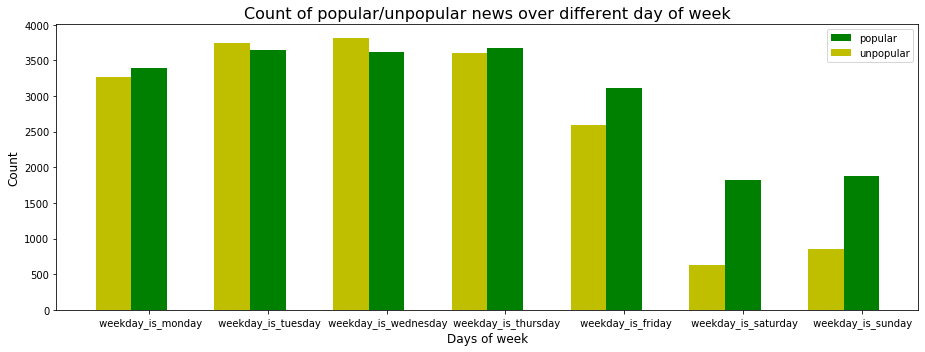

In [5]:
columns_day = features_raw.columns.values[29:36]
unpop=data[data[' shares']<1400]
pop=data[data[' shares']>=1400]
unpop_day = unpop[columns_day].sum().values
pop_day = pop[columns_day].sum().values

get_ipython().run_line_magic('matplotlib', 'inline')

fig = pl.figure(figsize = (13,5))
pl.title("Count of popular/unpopular news over different day of week", fontsize = 16)
pl.bar(np.arange(len(columns_day)), pop_day, width = 0.3, align="center", color = 'g', \
          label = "popular")
pl.bar(np.arange(len(columns_day)) - 0.3, unpop_day, width = 0.3, align = "center", color = 'y', \
          label = "unpopular")
pl.xticks(np.arange(len(columns_day)), columns_day)
pl.ylabel("Count", fontsize = 12)
pl.xlabel("Days of week", fontsize = 12)
    
pl.legend(loc = 'upper right')
pl.tight_layout()
pl.savefig("days.pdf")
pl.show()

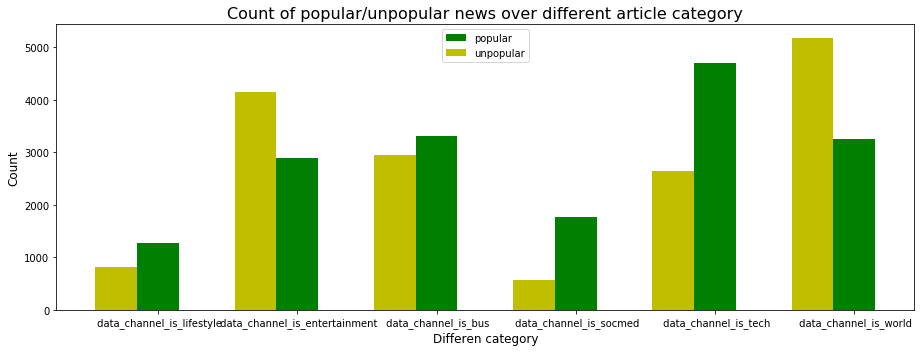

In [6]:
columns_chan=features_raw.columns.values[11:17]
unpop_chan = unpop[columns_chan].sum().values
pop_chan = pop[columns_chan].sum().values
fig = pl.figure(figsize = (13,5))
pl.title("Count of popular/unpopular news over different article category", fontsize = 16)
pl.bar(np.arange(len(columns_chan)), pop_chan, width = 0.3, align="center", color = 'g', \
          label = "popular")
pl.bar(np.arange(len(columns_chan)) - 0.3, unpop_chan, width = 0.3, align = "center", color = 'y', \
          label = "unpopular")
pl.xticks(np.arange(len(columns_chan)), columns_chan)

pl.ylabel("Count", fontsize = 12)
pl.xlabel("Differen category", fontsize = 12)
    
pl.legend(loc = 'upper center')
pl.tight_layout()
pl.savefig("chan.pdf")
pl.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical = [' n_tokens_title', ' n_tokens_content', ' num_hrefs', ' num_self_hrefs', ' num_imgs',' num_videos',\
            ' average_token_length',' num_keywords',' self_reference_min_shares',' self_reference_max_shares',\
             ' self_reference_avg_sharess']
features_raw[numerical] = scaler.fit_transform(data[numerical])
display(features_raw.head(n = 1))

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
0,0.47619,0.025844,0.663594,1.0,0.815385,0.013158,0.017241,0.007812,0.0,0.582024,...,0.378636,0.1,0.7,-0.35,-0.6,-0.2,0.5,-0.1875,0.0,0.1875


In [8]:
estimator_LR = LogisticRegression(random_state=0)
selector_LR = RFECV(estimator_LR, step=1, cv=5)
selector_LR = selector_LR.fit(features_raw, popular_label)
selector_LR.ranking_

estimator_RF = RandomForestClassifier(random_state=0)
selector_RF = RFECV(estimator_RF, step=1, cv=5)
selector_RF = selector_RF.fit(features_raw, popular_label)
selector_RF.ranking_

array([1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [9]:

print (features_raw.columns.values[selector_LR.ranking_==1].shape[0])
print (features_raw.columns.values[selector_LR.ranking_==1])
features_LR = features_raw[features_raw.columns.values[selector_LR.ranking_==1]]

print (features_raw.columns.values[selector_RF.ranking_!=1].shape[0])
print (features_raw.columns.values[selector_RF.ranking_!=1])
features_RF = features_raw[features_raw.columns.values[selector_RF.ranking_==1]]

28
[' n_tokens_title' ' n_unique_tokens' ' n_non_stop_words'
 ' average_token_length' ' data_channel_is_entertainment'
 ' data_channel_is_socmed' ' data_channel_is_tech'
 ' data_channel_is_world' ' kw_min_min' ' kw_min_avg' ' kw_avg_avg'
 ' weekday_is_monday' ' weekday_is_tuesday' ' weekday_is_wednesday'
 ' weekday_is_thursday' ' weekday_is_saturday' ' weekday_is_sunday'
 ' is_weekend' ' LDA_00' ' LDA_01' ' LDA_02' ' LDA_04'
 ' rate_negative_words' ' avg_positive_polarity' ' avg_negative_polarity'
 ' min_negative_polarity' ' title_sentiment_polarity'
 ' abs_title_subjectivity']
2
[' n_non_stop_words' ' data_channel_is_lifestyle']


In [10]:
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(features_LR, popular_label, test_size = 0.1, random_state = 0)
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(features_RF, popular_label, test_size = 0.1, random_state = 0)
print ("Training set: {}".format(X_train_LR.shape[0]))
print ("Testing set: {} ".format(X_test_LR.shape[0]))

Training set: 35679
Testing set: 3965 


In [11]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
     results = {}
     start = time() # Get start time
     learner.fit(X_train[:sample_size], y_train[:sample_size])
     end = time() # Get end time

     results['train_time'] = end-start
        
    # Get predictions on the first 4000 training samples
     start = time() # Get start time
     predictions_test = learner.predict(X_test)
     predictions_train = learner.predict(X_train[:4000])
     end = time() # Get end time
    
    # Calculate the total prediction time
     results['pred_time'] = end-start
            
    # Compute accuracy on the first 4000 training samples
     results['acc_train'] = accuracy_score(y_train[:4000],predictions_train)
        
    # Compute accuracy on test set
     results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # Compute F-score on the the first 4000 training samples
     results['f_train'] = fbeta_score(y_train[:4000],predictions_train,beta=1)
        
    # Compute F-score on the test set
     results['f_test'] = fbeta_score(y_test,predictions_test,beta=1)
       
    # Success
     print ("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
     print ("{} with accuracy {}, F1 {}".format(learner.__class__.__name__,\
          results['acc_test'],results['f_test']))   
    # Return the results
     return results
    
    # Initialize the three models
clf_B = LogisticRegression(random_state=0,C=1.0)
clf_C = RandomForestClassifier(random_state=0)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(X_train_LR.shape[0]*0.01)
samples_10 = int(X_train_LR.shape[0]*0.1)
samples_100 = X_train_LR.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_B,clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        if clf == clf_B:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_LR, y_train_LR, X_test_LR, y_test_LR)
        else:
            results[clf_name][i] = \
            train_predict(clf, samples, X_train_RF, y_train_RF, X_test_RF, y_test_RF)

LogisticRegression trained on 356 samples.
LogisticRegression with accuracy 0.603530895334174, F1 0.6226596255400864
LogisticRegression trained on 3567 samples.
LogisticRegression with accuracy 0.6292559899117276, F1 0.6731880835927079
LogisticRegression trained on 35679 samples.
LogisticRegression with accuracy 0.6426229508196721, F1 0.6765578635014837
RandomForestClassifier trained on 356 samples.
RandomForestClassifier with accuracy 0.594703656998739, F1 0.606994375152849
RandomForestClassifier trained on 3567 samples.
RandomForestClassifier with accuracy 0.6078184110970997, F1 0.6062294251709293
RandomForestClassifier trained on 35679 samples.
RandomForestClassifier with accuracy 0.6310214375788147, F1 0.6348889443473921


In [12]:
def gridsearch(clf,parameters,X_train, y_train, X_test, y_test):
    scorer = make_scorer(roc_auc_score)
    grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
    best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
    print (clf.__class__.__name__)
    print ("Unoptimized model\n------")
    print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions,beta=1)))
    print ("AUC on testing data: {:.4f}".format(roc_auc_score(y_test, predictions)))
    print ("\nOptimized Model\n------")
    print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=1)))

    print (best_clf)

In [13]:
parameters_RF = {"n_estimators": [10,20,50,100,250,500]}
parameters_LR = {"penalty": ['l1','l2'],
              "C": [0.1,0.5,1.,2.,2.5,5]}
gridsearch(clf_B,parameters_LR,X_train_LR, y_train_LR, X_test_LR, y_test_LR)
gridsearch(clf_C,parameters_RF,X_train_RF, y_train_RF, X_test_RF, y_test_RF)

LogisticRegression
Unoptimized model
------
Accuracy score on testing data: 0.6426
F-score on testing data: 0.6766
AUC on testing data: 0.6389

Optimized Model
------
Final accuracy score on the testing data: 0.6411
Final F-score on the testing data: 0.6752
LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
RandomForestClassifier
Unoptimized model
------
Accuracy score on testing data: 0.6310
F-score on testing data: 0.6349
AUC on testing data: 0.6321

Optimized Model
------
Final accuracy score on the testing data: 0.6767
Final F-score on the testing data: 0.7074
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
 